# Figure 4 – Verger-Miralles et al. (2025)

**SWOT enhances small-scale eddy detection in the Mediterranean Sea**

Author: *Elisabet Verger-Miralles*  
Institution: IMEDEA (CSIC-UIB)


In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import math
import cmath
from scipy.interpolate import griddata
from scipy.fft import fft, fftfreq
from scipy.interpolate import interp1d
import cmocean
import cartopy.crs           as ccrs
import cartopy.feature       as cfeature
import matplotlib.gridspec   as gridspec
from functions import *

In [2]:
trans = 6
dep = 80

# IMPORT DATA 

## ADCP

In [3]:
dir_adcp = '../../grl_codes_to_publish_def_swotv2.0.1/data/adcp/'
ds = xr.open_dataset(dir_adcp + 'adcp_selected_transects_fast_swot.nc')

In [4]:
df = ds.to_dataframe().reset_index(drop=False)

In [5]:
lon_adcp = np.array(df.loc[(df.transect_id==trans)& (df.depth==dep),'lon']) # basta a una prof, lon i lat a totes les prof. serà la mateixa
lat_adcp = np.array(df.loc[(df.transect_id==trans)& (df.depth==dep),'lat'])

In [6]:
u_adcp = df.loc[(df.transect_id==trans) & (df.depth==dep),'u']
v_adcp = df.loc[(df.transect_id==trans) & (df.depth==dep),'v']

### FILTER DATA

In [7]:
# Initialize the first point (start of the transect)
lat0, lon0 = lat_adcp[0], lon_adcp[0]

# Calculate distances from the first point to each point
distances = [haversine(lat0, lon0, lat, lon) for lat, lon in zip(lat_adcp, lon_adcp)]

# Generate regular distance intervals (0.25 km)
max_distance = distances[-1]
regular_distances = np.arange(0, max_distance, 0.25)

# Interpolation function
interpolator = interp1d(distances, list(zip(lat_adcp, lon_adcp)), axis=0, kind='linear')

# Interpolate latitudes and longitudes at regular distances
interpolated_points = interpolator(regular_distances)
interpolated_lats, interpolated_lons = interpolated_points.T

In [8]:
# Filter parameters
cutoff_distance = 0.067 # cutoff frequency in 1/5 km = 0.2, 1/10km = 0.1, 1/0.067 = 15 km
fs = 1 / (regular_distances[1] - regular_distances[0])  # sampling frequency

In [9]:
# Interpolation function for velocities
interpolator_u= interp1d(distances, u_adcp, kind='linear')
interpolator_v= interp1d(distances, v_adcp, kind='linear')

# Interpolate velocities at regular distances
interpolated_u = interpolator_u(regular_distances)
interpolated_v = interpolator_v(regular_distances)

# Apply the low-pass filter to the interpolated velocities
u_filtered = low_pass_filter(interpolated_u, cutoff_distance, fs)
v_filtered = low_pass_filter(interpolated_v, cutoff_distance, fs)

### COMPUTE CROSS-SECTION VELOCITIES

In [10]:
# Coordinates of two points of the section (used to compute angle)
lon1=1.41;
lat1=39.65;
lon2=1.58;
lat2=40;

In [11]:
# Compute angle 
dlon=lon1-lon2;
dlat=lat1-lat2;
mean_lat = math.radians((lat1 + lat2) / 2.0) # in radians
angle=np.rad2deg(np.arctan2(dlat,dlon*math.cos(mean_lat)));   # 0 is West, +90 is North, 180 is East, -90 is South, -180 is East

In [12]:
# Calculate the rotated complex number
uv_rotated = (u_filtered + 1j*v_filtered) * cmath.exp(1j * (-angle) * cmath.pi / 180)
uv_rotated_unfiltered = (u_adcp+ 1j*v_adcp) * cmath.exp(1j * (-angle) * cmath.pi / 180)

# Extract along- and cross-section values
uv_along = uv_rotated.real
uv_cross = np.array(uv_rotated).imag
uv_cross_unfiltered = np.array(uv_rotated_unfiltered).imag

## SWOT

In [13]:
dir_SWOT = '../../grl_codes_to_publish_def_swotv2.0.1/data/SWOT/'
file_swot = 'SWOT_L3_LR_SSH_Expert_502_016_20230426T062612_20230426T071716_v2.0.1.nc' # 26 april

In [14]:
ds_SWOT = xr.open_dataset(dir_SWOT+file_swot)
ds_SWOT

<xarray.Dataset> Size: 99MB
Dimensions:               (num_lines: 9860, num_pixels: 69, num_nadir: 1311)
Coordinates:
    latitude              (num_lines, num_pixels) float64 5MB ...
    longitude             (num_lines, num_pixels) float64 5MB ...
Dimensions without coordinates: num_lines, num_pixels, num_nadir
Data variables: (12/21)
    time                  (num_lines) datetime64[ns] 79kB ...
    calibration           (num_lines, num_pixels) float64 5MB ...
    cross_track_distance  (num_pixels) float64 552B ...
    dac                   (num_lines, num_pixels) float64 5MB ...
    internal_tide         (num_lines, num_pixels) float64 5MB ...
    mdt                   (num_lines, num_pixels) float64 5MB ...
    ...                    ...
    ugosa_unfiltered      (num_lines, num_pixels) float64 5MB ...
    vgos_filtered         (num_lines, num_pixels) float64 5MB ...
    vgosa_filtered        (num_lines, num_pixels) float64 5MB ...
    vgosa_unfiltered      (num_lines, num_pixels) float64 5MB ...
    i_num_line            (num_nadir) int16 3kB ...
    i_num_pixel           (num_nadir) int8 1kB ...
Attributes: (12/42)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    data_used:                       SWOT KaRIn L2_LR_SSH PGC0/PIC0/PIC2 (NAS...
    doi:                             https://doi.org/10.24400/527896/A01-2023...
    ...                              ...
    geospatial_lon_min:              6.5e-05
    geospatial_lon_max:              359.999908
    date_modified:                   2025-03-04T17:09:49Z
    history:                         2025-03-04T17:09:49Z: Created by DUACS K...
    date_created:                    2025-03-04T17:09:49Z
    date_issued:                     2025-03-04T17:09:49Z

Interpolate SWOT to ADCP transect

In [15]:
lon_min = lon_adcp.min()-0.5
lon_max = lon_adcp.max()+0.5
lat_min = lat_adcp.min()-0.5
lat_max = lat_adcp.max()+0.5
 
# Select subregion:
ds_SWOT = ds_SWOT.where(ds_SWOT['longitude'].compute()<lon_max, drop=True)
ds_SWOT = ds_SWOT.where(ds_SWOT['longitude'].compute()>lon_min, drop=True)
ds_SWOT = ds_SWOT.where(ds_SWOT['latitude'].compute()<lat_max, drop=True)
ds_SWOT = ds_SWOT.where(ds_SWOT['latitude'].compute()>lat_min, drop=True)

In [16]:
ds_SWOT

<xarray.Dataset> Size: 71MB
Dimensions:               (num_lines: 97, num_pixels: 69, num_nadir: 1311)
Coordinates:
    latitude              (num_lines, num_pixels) float64 54kB 40.8 ... 38.84
    longitude             (num_lines, num_pixels) float64 54kB 2.541 ... 1.504
Dimensions without coordinates: num_lines, num_pixels, num_nadir
Data variables: (12/21)
    time                  (num_lines, num_pixels) datetime64[ns] 54kB NaT ......
    calibration           (num_lines, num_pixels) float64 54kB nan nan ... nan
    cross_track_distance  (num_pixels, num_lines) float64 54kB nan nan ... nan
    dac                   (num_lines, num_pixels) float64 54kB nan nan ... nan
    internal_tide         (num_lines, num_pixels) float64 54kB nan nan ... nan
    mdt                   (num_lines, num_pixels) float64 54kB nan nan ... nan
    ...                    ...
    ugosa_unfiltered      (num_lines, num_pixels) float64 54kB nan nan ... nan
    vgos_filtered         (num_lines, num_pixels) float64 54kB nan nan ... nan
    vgosa_filtered        (num_lines, num_pixels) float64 54kB nan nan ... nan
    vgosa_unfiltered      (num_lines, num_pixels) float64 54kB nan nan ... nan
    i_num_line            (num_nadir, num_lines, num_pixels) float32 35MB nan...
    i_num_pixel           (num_nadir, num_lines, num_pixels) float32 35MB nan...
Attributes: (12/42)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    data_used:                       SWOT KaRIn L2_LR_SSH PGC0/PIC0/PIC2 (NAS...
    doi:                             https://doi.org/10.24400/527896/A01-2023...
    ...                              ...
    geospatial_lon_min:              6.5e-05
    geospatial_lon_max:              359.999908
    date_modified:                   2025-03-04T17:09:49Z
    history:                         2025-03-04T17:09:49Z: Created by DUACS K...
    date_created:                    2025-03-04T17:09:49Z
    date_issued:                     2025-03-04T17:09:49Z

In [17]:
ssha_unfiltered = ds_SWOT.ssha_unfiltered.values.flatten()[~np.isnan(ds_SWOT.ssha_unfiltered.values.flatten())]
ssha_filtered = ds_SWOT.ssha_filtered.values.flatten()[~np.isnan(ds_SWOT.ssha_unfiltered.values.flatten())]
mdt = ds_SWOT.mdt.values.flatten()[~np.isnan(ds_SWOT.ssha_unfiltered.values.flatten())]
ssh = ssha_filtered + mdt

lon_swot = ds_SWOT.longitude.values.flatten()[~np.isnan(ds_SWOT.ugos_filtered.values.flatten())]
lat_swot = ds_SWOT.latitude.values.flatten()[~np.isnan(ds_SWOT.ugos_filtered.values.flatten())]
u_swot = ds_SWOT.ugos_filtered.values.flatten()[~np.isnan(ds_SWOT.ugos_filtered.values.flatten())]
v_swot = ds_SWOT.vgos_filtered.values.flatten()[~np.isnan(ds_SWOT.vgos_filtered.values.flatten())]

In [18]:
u_interp = griddata((lon_swot, lat_swot), u_swot, (interpolated_lons, interpolated_lats), method='cubic')
v_interp = griddata((lon_swot, lat_swot), v_swot, (interpolated_lons, interpolated_lats), method='cubic')

Compute cross-velocity from SWOT

In [19]:
# Calculate the rotated complex number
uv_SWOT_rotated = (u_interp + 1j*v_interp) * cmath.exp(1j * (-angle) * cmath.pi / 180)

# Extract along- and cross-section values
# uv_SWOT_along = uv_SWOT_rotated.real
uv_SWOT_cross = uv_SWOT_rotated.imag

## DUACS

In [20]:
dir_DUACS = '../../grl_codes_to_publish_def_swotv2.0.1/data/DUACS_new/'
file_duacs = "cmems_obs-sl_eur_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D_20230426.nc"

In [21]:
ds_duacs= xr.open_dataset(dir_DUACS + file_duacs)

In [22]:
lon_duacs, lat_duacs = np.meshgrid(ds_duacs.longitude, ds_duacs.latitude)

In [23]:
u_duacs_interp = griddata((lon_duacs.ravel(),lat_duacs.ravel()), np.array(ds_duacs.ugos).ravel(), (interpolated_lons, interpolated_lats))
v_duacs_interp = griddata((lon_duacs.ravel(),lat_duacs.ravel()), np.array(ds_duacs.vgos).ravel(), (interpolated_lons, interpolated_lats))

Compute cross-velocity from DUACS

In [24]:
# Calculate the rotated complex number
uv_DUACS_rotated = (u_duacs_interp + 1j*v_duacs_interp) * cmath.exp(1j * (-angle) * cmath.pi / 180)

# Extract along- and cross-section values
# uv_SWOT_along = uv_SWOT_rotated.real
uv_DUACS_cross = uv_DUACS_rotated.imag

***

## FIGURE


In [25]:
lonminz, lonmaxz, latminz, latmaxz = 1.4, 1.8,39.65,40

PLOT SECTION OFCROSS-SECTION VELOCITIES:

In [26]:
Depth  = ds.depth

Time = ds.time[ds['transect_id']==6].values

Lat = ds['lat'].where(ds['transect_id']==6, drop=True)
Lon = ds['lon'].where(ds['transect_id']==6, drop=True)
V = ds['v'].where(ds['transect_id']==6, drop=True)
U = ds['u'].where(ds['transect_id']==6, drop=True)

In [27]:
# Calculate the rotated complex number
uv_rotated_trans = (U + 1j*V) * cmath.exp(1j * (-angle) * cmath.pi / 180)

# Extract along- and cross-section values
#uv_along = uv_rotated.real
uv_cross_trans = np.array(uv_rotated_trans).imag

np.shape(uv_cross_trans)

(256, 40)

interpolate the full section


In [28]:
# Initialize the matrix to store interpolated values
new_uv_cross_trans = np.zeros((len(regular_distances), len(Depth.values)))

for i in range(len(Depth.values)):  # Loop over each depth layer
    # Interpolate the current depth layer
    f = interp1d(distances, uv_cross_trans[:, i], kind='linear', fill_value='extrapolate')
    
    interpolated_uv = f(regular_distances)
    
    # Handle potential NaNs after interpolation 
    interpolated_uv = np.nan_to_num(interpolated_uv, nan=0.0)  
    
    # Apply low-pass filter to the interpolated values
    smoothed_uv = low_pass_filter(interpolated_uv, cutoff_distance, fs)
    
    # Optionally handle NaNs after smoothing
    smoothed_uv = np.nan_to_num(smoothed_uv, nan=0.0) 
    
    # Store the smoothed result
    new_uv_cross_trans[:, i] = smoothed_uv


COMPUTE RO:


In [29]:
# Compute vorticity
zeta = compute_vorticity_2d(new_uv_cross_trans.T, regular_distances*1000)  

In [30]:
# Compute Rossby number using a single latitude value
Ro = compute_rossby_number_2d(zeta, 30)

PLOT:

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4740\2295176278.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax1.plot(regular_distances, uv_SWOT_cross*100, 'r', linewidth = 2, label='SWOT', color='coral')


Text(1.01, 0.95, '(d)')

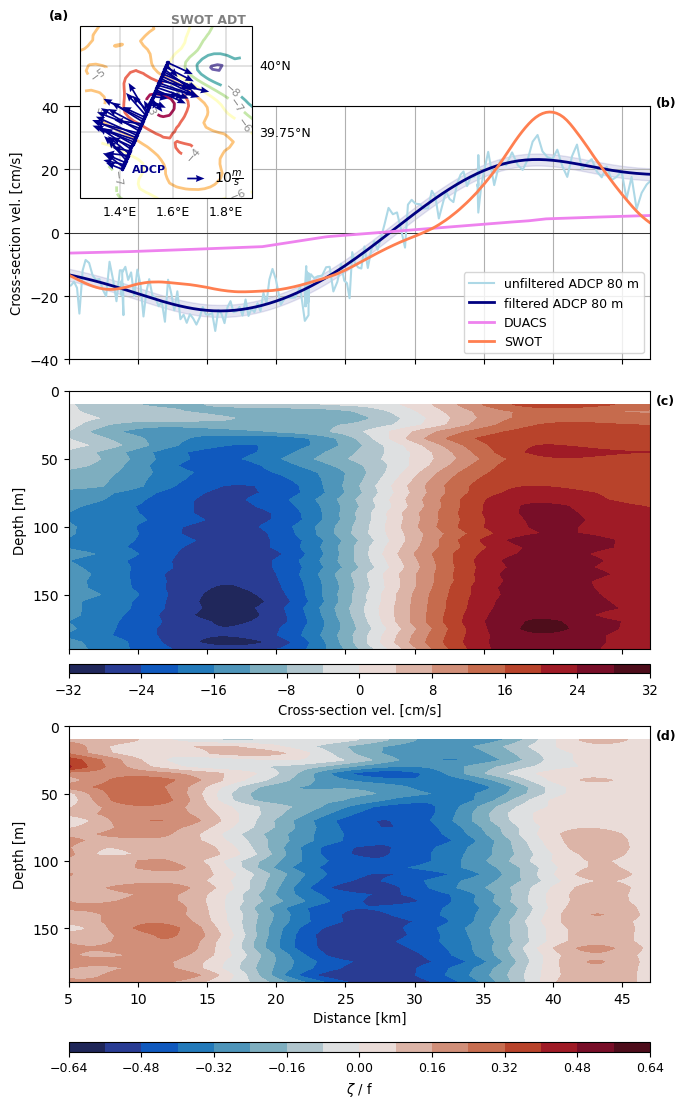

In [31]:
fig = plt.figure(figsize=(7.5, 12))

gs = fig.add_gridspec(3, 1, height_ratios=[1, 1.2, 1.2])

# FIRST SUBPLOT #############################################
ax1 = fig.add_subplot(gs[0, 0])

ax1.grid(visible=True)
#add line in 0
ax1.axhline(0, color='black', lw=0.5)

ax1.plot(distances[:-21],uv_cross_unfiltered[:-21]*100,  label='unfiltered ADCP '+str(dep)+' m', color='lightblue')
ax1.plot(regular_distances, uv_cross*100, linewidth = 2,label='filtered ADCP '+str(dep)+' m', color='navy')        

plt.fill_between(regular_distances, (uv_cross*100) - 1.9, (uv_cross*100) + 1.9, color='navy', alpha=0.1)

ax1.plot(regular_distances,uv_DUACS_cross*100,linewidth = 2, label='DUACS',c='violet')
ax1.plot(regular_distances, uv_SWOT_cross*100, 'r', linewidth = 2, label='SWOT', color='coral') 

ax1.set_xlim(5,47)
ax1.set_ylim([-40, 40])
ax1.set_ylabel('Cross-section vel. [cm/s]', fontsize=9.5)
ax1.legend(loc = 'lower right', fontsize=9)
ax1.locator_params(axis='y', nbins=5)
ax1.set_xticklabels([])

# SECOND SUBPLOT ############################################
ax2 = fig.add_subplot(gs[1, 0])

pc2 = plt.contourf(regular_distances,Depth.values,new_uv_cross_trans.T*100,levels = 14, cmap=cmocean.cm.balance)

ax2.invert_yaxis()

ax2.set_ylabel('Depth [m]', fontsize=9.5)
ax2.locator_params(axis='y', nbins=5)

# no ticks in x axis
ax2.set_xticklabels([])

# set ylim
ax2.set_ylim([190, 0])
ax2.set_xlim(5,47)

cbar = fig.colorbar(pc2, ax=ax2, label='Cross-section vel. [cm/s]', orientation='horizontal', aspect=60, pad = 0.001, anchor=(0.5, 0.6))
# change colorbar ticks size
cbar.ax.tick_params(labelsize=9.5)
cbar.set_label(label='Cross-section vel. [cm/s]', size=9.5)

# THIRD SUBPLOT ############################################
ax3 = fig.add_subplot(gs[2, 0])

pc3 = ax3.contourf(regular_distances, Depth.values, Ro, levels = 14, cmap=cmocean.cm.balance)

ax3.invert_yaxis()

ax3.set_xlabel('Distance [km]',fontsize=9.5)
ax3.set_ylabel('Depth [m]', fontsize=9.5)
ax3.locator_params(axis='y', nbins=5)

ax3.set_ylim([190, 0])
ax3.set_xlim(5,47)

cbar3 = fig.colorbar(pc3, ax=ax3, label=r'$\zeta$ / f', orientation='horizontal', aspect=60, pad = 0.009, anchor=(0.5, -0.6))

# change colorbar ticks size
cbar3.ax.tick_params(labelsize=9)
# change colorbar label size
cbar3.ax.yaxis.label.set_size(9.5)
cbar3.set_label(label=r'$\zeta$ / f', size=9.5)


##################### MAP ########################################
inset_ax = fig.add_axes([0.14, 0.76, 0.23, 0.23], projection=ccrs.PlateCarree())  
inset_ax.set_extent([1.25, 1.9, 39.5, 40.15], ccrs.PlateCarree())

CS=inset_ax.contour(ds_SWOT.longitude, ds_SWOT.latitude, (ds_SWOT.ssha_filtered + ds_SWOT.mdt) * 100, 
                 cmap='Spectral_r', linewidths = 2, alpha = 0.9, vmin=-9,vmax=-3, levels = 7, transform=ccrs.PlateCarree())

# Add labels to contours
inset_ax.clabel(CS, inline=True, fontsize=8, colors='gray')

# title inside plot
inset_ax.text(0.96, 1.075, 'SWOT ADT', transform=inset_ax.transAxes, fontsize=9, va='top', ha='right', color='gray', fontweight = 'bold')
inset_ax.text(0.5, 0.2, 'ADCP', color= 'darkblue', transform=inset_ax.transAxes, fontweight= 'bold',fontsize=8, va='top', ha='right')

q = inset_ax.quiver(interpolated_lons[::4],interpolated_lats[::4], interpolated_u[::4], interpolated_v[::4],  scale=1, zorder=10, 
                transform=ccrs.PlateCarree(), width=0.01, headwidth=4, color= 'darkblue')

inset_ax.scatter(interpolated_lons,interpolated_lats,8,marker='.',color='darkblue',zorder=10)

qk = plt.quiverkey(q, 0.305, 0.82, 0.1, r'$10 \frac{m}{s}$', labelpos='E', coordinates='figure',color='darkblue')

gl = inset_ax.gridlines(draw_labels=True, linewidth=0.2, color='black', alpha=0.8, linestyle='-', zorder=10)

gl.xlabel_style = {'size': 9}
gl.ylabel_style = {'size': 9}
gl.top_labels = False
gl.left_labels = False

gl.ylocator = plt.MaxNLocator(3)  
gl.xlocator = plt.MaxNLocator(4)

plt.subplots_adjust(hspace=0.11)

# a,b,c
plt.text(1.01, 1, '(b)', transform=ax1.transAxes, fontsize=9, fontweight='bold')
plt.text(1.01, 0.95, '(c)', transform=ax2.transAxes, fontsize=9, fontweight='bold')
plt.text(-0.18, 1.04, '(a)', transform=inset_ax.transAxes, fontsize=9, fontweight='bold')
plt.text(1.01, 0.95, '(d)', transform=ax3.transAxes, fontsize=9, fontweight='bold')

# plt.savefig('C:/Users/ASUS/OneDrive - Universitat de les Illes Balears/grl_codes_to_publish_def_swotv2.0.1/figures_def/figure4.png',dpi=600, bbox_inches='tight')


COMPUTE MAXIMUM AND MINIMUM VELOCITIES:

In [32]:
# Find the index of the maximum absolute velocity across all latitudes and depths
max_vel_idx = np.unravel_index(np.nanargmax(new_uv_cross_trans), new_uv_cross_trans.shape)

# Extract the corresponding depth
depth_max_velocity = Depth.values[max_vel_idx[1]]

# Extract the maximum velocity value
max_velocity = new_uv_cross_trans[max_vel_idx]

print(f"Maximum velocity: {max_velocity}")
print(f"Depth at maximum velocity: {depth_max_velocity}")


Maximum velocity: 0.28820331550721334
Depth at maximum velocity: 175


In [33]:
# Find the index of the maximum absolute velocity across all latitudes and depths
min_vel_idx = np.unravel_index(np.nanargmin(new_uv_cross_trans), new_uv_cross_trans.shape)

# Extract the corresponding depth
depth_min_velocity = Depth.values[min_vel_idx[1]] 

# Extract the maximum velocity value
min_velocity = new_uv_cross_trans[min_vel_idx]

print(f"Minimum velocity: {min_velocity}")
print(f"Depth at minimum velocity: {depth_min_velocity}")

Minimum velocity: -0.2986770307757118
Depth at minimum velocity: 155
